<!-- WARNING: THIS FILE WAS AUTOGENERATED! DO NOT EDIT! -->

In [62]:
import torchvision.transforms.functional as TF
from fastcore.test import test_close

torch.set_printoptions(precision=2, linewidth=140, sci_mode=False)
torch.manual_seed(1)
mpl.rcParams['image.cmap'] = 'gray_r'

In [63]:
import logging
logging.disable(logging.WARNING)

## Hugging Face Datasets

Note that a list of the available can be found on the Hugging Face hub: 

[Hugging Face Hub](https://huggingface.co/datasets)

In [64]:
name = "fashion_mnist"
ds_builder = load_dataset_builder(name)
print(ds_builder.info.description)

Fashion-MNIST is a dataset of Zalando's article images—consisting of a training set of
60,000 examples and a test set of 10,000 examples. Each example is a 28x28 grayscale image,
associated with a label from 10 classes. We intend Fashion-MNIST to serve as a direct drop-in
replacement for the original MNIST dataset for benchmarking machine learning algorithms.
It shares the same image size and structure of training and testing splits.



The dataset builder has a number of useful properties that can help better understand a dataset.  These are mostly sub properties the info attribute and include:
- features
- splits
- homepage

And lots of other useful things.

Dataset builder allows obtaining details about he dataset without actually downloading it.  Accessing the dataset then uses the load_dataet mehod

In [65]:
ds_builder.info.features

{'image': Image(decode=True, id=None),
 'label': ClassLabel(names=['T - shirt / top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot'], id=None)}

In [66]:
ds_builder.info.splits

{'train': SplitInfo(name='train', num_bytes=31296607, num_examples=60000, shard_lengths=None, dataset_name='fashion_mnist'),
 'test': SplitInfo(name='test', num_bytes=5233810, num_examples=10000, shard_lengths=None, dataset_name='fashion_mnist')}

In [67]:
ds_loader = load_dataset(name)

  0%|          | 0/2 [00:00<?, ?it/s]

The ds_loader object contains the whole dataset.  We can extact the splits into separate datasets

In [68]:
train_ds, test_ds = ds_loader['train'], ds_loader['test']

In [69]:
train_ds[0]

{'image': <PIL.PngImagePlugin.PngImageFile image mode=L size=28x28>,
 'label': 9}

The way the Hugging Face datasets work is through the use of dictionaries.  To make it easy to access the values it is easiest to assign the keys into variables so that they can be used to retireve the values more easily

In [70]:
x, y = ds_builder.info.features
x, y

('image', 'label')

Load and display an x value

In [71]:
img = train_ds[0][x]
img

To fully unlock the label it helps to have effectively a conversion.  The dataset features attribute then has a key names, which can be indexed to return the class label for a class index.  The class contains a method int2str to achieve this for a list

In [72]:
featy = train_ds.features[y]
featy

ClassLabel(names=['T - shirt / top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot'], id=None)

In [73]:
xb, yb = train_ds[:5][x], train_ds[:5][y]

In [74]:
yb

[9, 0, 0, 3, 0]

In [75]:
yb_labels = featy.int2str(yb)
yb_labels

['Ankle boot',
 'T - shirt / top',
 'T - shirt / top',
 'Dress',
 'T - shirt / top']

In [76]:
train_ds[0:3]

{'image': [<PIL.PngImagePlugin.PngImageFile image mode=L size=28x28>,
  <PIL.PngImagePlugin.PngImageFile image mode=L size=28x28>,
  <PIL.PngImagePlugin.PngImageFile image mode=L size=28x28>],
 'label': [9, 0, 0]}

#### Creating a collate function to work with this dataset

A function is needed to facilitate loading a batch of data returned from the dataset into stacked torch tensors

input: a batch of data returned by the dataset getitems

In [77]:
def collate_fn(b):
    var_dict = {x: torch.stack([TF.to_tensor(xys[x]) for xys in b]),
                y: tensor([xys[y] for xys in b])}
    return var_dict

In [78]:
dl=DataLoader(train_ds, collate_fn=collate_fn, batch_size=16)

In [79]:
batch = next(iter(dl))
batch[y]

tensor([9, 0, 0, 3, 0, 2, 7, 2, 5, 5, 0, 9, 5, 5, 7, 9])

In [80]:
batch[x].shape

torch.Size([16, 1, 28, 28])

#### Start to build the transforms into the dataloader process 

In [81]:
def transforms(batch):
    # Note that this will only process the x values
    batch[x] = [TF.to_tensor(xys) for xys in batch[x]]
    return batch

The Hugging Face dataset contains a method with_transform that applies a transform to a batch immediately before it is returned.  It looks as though it automatically converts the y values into a torch array

In [82]:
tls = train_ds.with_transform(transforms)
dl = DataLoader(tls, batch_size=16)
b = next(iter(dl))
b[x].shape, b[y]

(torch.Size([16, 1, 28, 28]),
 tensor([9, 0, 0, 3, 0, 2, 7, 2, 5, 5, 0, 9, 5, 5, 7, 9]))

The image needs to be flattened prior to returning and so the transforms can be modified

In [83]:
def _transformi(batch):
    # Note that this will only process the x values
    batch[x] = [torch.flatten(TF.to_tensor(xys)) for xys in batch[x]]
    return batch

Don't fully understand the inplace function below.  It looks as though when a function is called it returns the new value over the existing value

In [1]:
#| echo: false
#| output: asis
show_doc(inplace)

---

[source](https://github.com/fastai/fastai-course-22p/blob/master/miniai/datasets.py#L21){target="_blank" style="float:right; font-size:smaller"}

### inplace

>      inplace (f)

In [85]:
transformi = inplace(_transformi)

In [86]:
r = train_ds.with_transform(transformi)[0]
r[x].shape,r[y]

(torch.Size([784]), 9)

The above function can then be used as a decorator

In [87]:
@inplace
def transformi(batch): batch[x] = [torch.flatten(TF.to_tensor(xbs)) for xbs in batch[x]]

In [88]:
tdsf = train_ds.with_transform(transformi)
r = tdsf[0]
r[x].shape, r[y]

(torch.Size([784]), 9)

#### Add in the collate_dict

In [89]:
class Demo():
    def __getitem__(self, k):
        return 1 if k=='a' else 2 if k=='b' else 3

In [90]:
demo = Demo()
demo['a']

1

Adding in the itemgetter function, which is a way to return a tuple of items based upon a variable length set of inputs.  Note that it only returns the highest level of the class properties.  The * before the variable makes it look for multiple inputs, and I think it therefore picks the keys adn not the values one level down

In [91]:
ig = itemgetter('a', 'c')
ig(demo)

(1, 3)

The batch returned from the dataset provides data in the form below:

In [92]:
batch = dict(a=[1],b=[2]), dict(a=[3],b=[4])
batch

({'a': [1], 'b': [2]}, {'a': [3], 'b': [4]})

In [93]:
default_collate(batch)

{'a': [tensor([1, 3])], 'b': [tensor([2, 4])]}

In [94]:
# This will get the properties 'image', 'label' from whatever it is used against
get = itemgetter(*tdsf.features)
get

operator.itemgetter('image', 'label')

In [95]:
# This function will get the values associated wiht the keys defined in get.  In other words it will 
# return a list of tensors for image and label
def _f(b): return get(default_collate(b))

In [2]:
#| echo: false
#| output: asis
show_doc(collate_dict)

---

[source](https://github.com/fastai/fastai-course-22p/blob/master/miniai/datasets.py#L28){target="_blank" style="float:right; font-size:smaller"}

### collate_dict

>      collate_dict (ds)

Putting it all together we get tdsf as a dataset (which returns values that have had any required transforms applied.  Collate_dict(ds) return a function that will process the data it is supplied with (b) but use the itemgetter defined for the dataset (ie by the dataset features).  This is why it is necessary to pass in tdsf when defining the dataloader.  ds is not what is applied by the dataloader, it is the function returned by collate_dict when setup for the appropriate type , ie by setting the itemgetter to select the correct dictionary keys

In [97]:
test_fn = collate_dict(tdsf)

In [98]:
dlf = DataLoader(tdsf, batch_size=4, collate_fn=collate_dict(tdsf))
xb,xb = next(iter(dlf))
xb.shape,yb

(torch.Size([4]), [9, 0, 0, 3, 0])

In [99]:
# Create a mini-batch to test the collate function.  This is as it would be supplied from the data loader
# to the collate function
mini_batch = [tdsf[i] for i in range(4)]
mini_batch[0]['image'].shape

torch.Size([784])

Feeding the mini-batch through the collate function gives the required outputs

In [100]:
collate_dict(tdsf)(mini_batch)

(tensor([[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]),
 tensor([9, 0, 0, 3]))

## Plotting Images
Plotting can be done using the matplotlib function imshow, however, this is cumbersome to setup in a way that makes it easy to use with a variable number of images, applying labels and configuring correctly.  A way to improve that is developed here.  This makes use of the fastcore library to understand available kwargs, which can often be a problem 

imshow features to include:
variable figsize
input ax if required
Assign tiles to the overall plot
set a frame or not
pass in kwargs to imshow

Permute axis if required from CHW to HWC
Convert to array if required
Create axes if required
remove ticks from axis
Remove empty channel axis if only one channel

Return the image as an axis

In [101]:
from matplotlib.pyplot import axes as ax

In [3]:
#| echo: false
#| output: asis
show_doc(show_image)

/Users/johnrichmond/miniconda/envs/fastai/lib/python3.9/site-packages/fastcore/docscrape.py:225: UserWarning: Unknown section Other Parameters
  else: warn(msg)
/Users/johnrichmond/miniconda/envs/fastai/lib/python3.9/site-packages/fastcore/docscrape.py:225: UserWarning: Unknown section See Also
  else: warn(msg)
/Users/johnrichmond/miniconda/envs/fastai/lib/python3.9/site-packages/fastcore/docscrape.py:225: UserWarning: Unknown section Notes
  else: warn(msg)


---

[source](https://github.com/fastai/fastai-course-22p/blob/master/miniai/datasets.py#L38){target="_blank" style="float:right; font-size:smaller"}

### show_image

>      show_image (img, ax=None, title=None, with_frame=False, figsize=None,
>                  cmap=None, norm=None, aspect=None, interpolation=None,
>                  alpha=None, vmin=None, vmax=None, origin=None, extent=None,
>                  interpolation_stage=None, filternorm=True, filterrad=4.0,
>                  resample=None, url=None, data=None)

|    | **Type** | **Default** | **Details** |
| -- | -------- | ----------- | ----------- |
| img |  |  |  |
| ax | NoneType | None |  |
| title | NoneType | None |  |
| with_frame | bool | False |  |
| figsize | NoneType | None |  |
| cmap | NoneType | None | The Colormap instance or registered colormap name used to map scalar data<br>to colors.<br><br>This parameter is ignored if *X* is RGB(A). |
| norm | NoneType | None | The normalization method used to scale scalar data to the [0, 1] range<br>before mapping to colors using *cmap*. By default, a linear scaling is<br>used, mapping the lowest value to 0 and the highest to 1.<br><br>If given, this can be one of the following:<br><br>- An instance of `.Normalize` or one of its subclasses<br>  (see :doc:`/tutorials/colors/colormapnorms`).<br>- A scale name, i.e. one of "linear", "log", "symlog", "logit", etc.  For a<br>  list of available scales, call `matplotlib.scale.get_scale_names()`.<br>  In that case, a suitable `.Normalize` subclass is dynamically generated<br>  and instantiated.<br><br>This parameter is ignored if *X* is RGB(A). |
| aspect | NoneType | None | The aspect ratio of the Axes.  This parameter is particularly<br>relevant for images since it determines whether data pixels are<br>square.<br><br>This parameter is a shortcut for explicitly calling<br>`.Axes.set_aspect`. See there for further details.<br><br>- 'equal': Ensures an aspect ratio of 1. Pixels will be square<br>  (unless pixel sizes are explicitly made non-square in data<br>  coordinates using *extent*).<br>- 'auto': The Axes is kept fixed and the aspect is adjusted so<br>  that the data fit in the Axes. In general, this will result in<br>  non-square pixels. |
| interpolation | NoneType | None | The interpolation method used.<br><br>Supported values are 'none', 'antialiased', 'nearest', 'bilinear',<br>'bicubic', 'spline16', 'spline36', 'hanning', 'hamming', 'hermite',<br>'kaiser', 'quadric', 'catrom', 'gaussian', 'bessel', 'mitchell',<br>'sinc', 'lanczos', 'blackman'.<br><br>If *interpolation* is 'none', then no interpolation is performed<br>on the Agg, ps, pdf and svg backends. Other backends will fall back<br>to 'nearest'. Note that most SVG renderers perform interpolation at<br>rendering and that the default interpolation method they implement<br>may differ.<br><br>If *interpolation* is the default 'antialiased', then 'nearest'<br>interpolation is used if the image is upsampled by more than a<br>factor of three (i.e. the number of display pixels is at least<br>three times the size of the data array).  If the upsampling rate is<br>smaller than 3, or the image is downsampled, then 'hanning'<br>interpolation is used to act as an anti-aliasing filter, unless the<br>image happens to be upsampled by exactly a factor of two or one.<br><br>See<br>:doc:`/gallery/images_contours_and_fields/interpolation_methods`<br>for an overview of the supported interpolation methods, and<br>:doc:`/gallery/images_contours_and_fields/image_antialiasing` for<br>a discussion of image antialiasing.<br><br>Some interpolation methods require an additional radius parameter,<br>which can be set by *filterrad*. Additionally, the antigrain image<br>resize filter is controlled by the parameter *filternorm*. |
| alpha | NoneType | None | The alpha blending value, between 0 (transparent) and 1 (opaque).<br>If *alpha* is an array, the alpha blending values are applied pixel<br>by pixel, and *alpha* must have the same shape as *X*. |
| vmin | NoneType | None |  |
| vmax | NoneType | None |  |
| origin | NoneType | None | Place the [0, 0] index of the array in the upper left or lower<br>left corner of the Axes. The convention (the default) 'upper' is<br>typically used for matrices and images.<br><br>Note that the vertical axis points upward for 'lower'<br>but downward for 'upper'.<br><br>See the :doc:`/tutorials/intermediate/imshow_extent` tutorial for<br>examples and a more detailed description. |
| extent | NoneType | None | The bounding box in data coordinates that the image will fill.<br>The image is stretched individually along x and y to fill the box.<br><br>The default extent is determined by the following conditions.<br>Pixels have unit size in data coordinates. Their centers are on<br>integer coordinates, and their center coordinates range from 0 to<br>columns-1 horizontally and from 0 to rows-1 vertically.<br><br>Note that the direction of the vertical axis and thus the default<br>values for top and bottom depend on *origin*:<br><br>- For ``origin == 'upper'`` the default is<br>  ``(-0.5, numcols-0.5, numrows-0.5, -0.5)``.<br>- For ``origin == 'lower'`` the default is<br>  ``(-0.5, numcols-0.5, -0.5, numrows-0.5)``.<br><br>See the :doc:`/tutorials/intermediate/imshow_extent` tutorial for<br>examples and a more detailed description. |
| interpolation_stage | NoneType | None | If 'data', interpolation<br>is carried out on the data provided by the user.  If 'rgba', the<br>interpolation is carried out after the colormapping has been<br>applied (visual interpolation). |
| filternorm | bool | True | A parameter for the antigrain image resize filter (see the<br>antigrain documentation).  If *filternorm* is set, the filter<br>normalizes integer values and corrects the rounding errors. It<br>doesn't do anything with the source floating point values, it<br>corrects only integers according to the rule of 1.0 which means<br>that any sum of pixel weights must be equal to 1.0.  So, the<br>filter function must produce a graph of the proper shape. |
| filterrad | float | 4.0 | The filter radius for filters that have a radius parameter, i.e.<br>when interpolation is one of: 'sinc', 'lanczos' or 'blackman'. |
| resample | NoneType | None | When *True*, use a full resampling method.  When *False*, only<br>resample when the output image is larger than the input image. |
| url | NoneType | None | Set the url of the created `.AxesImage`. See `.Artist.set_url`. |
| data | NoneType | None |  |

The fastcore library now gives a list of all of the parameters that can be passed as kwargs, for example interpolation.

In [103]:
help(show_image)

Help on function show_image in module __main__:

show_image(img, ax=None, title=None, with_frame=False, figsize=None, *, cmap=None, norm=None, aspect=None, interpolation=None, alpha=None, vmin=None, vmax=None, origin=None, extent=None, interpolation_stage=None, filternorm=True, filterrad=4.0, resample=None, url=None, data=None)
    #|export



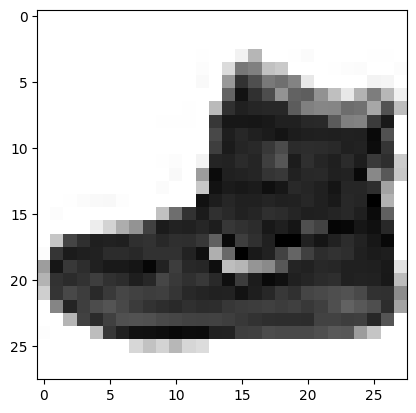

In [104]:
# Load a sample image to display
b = next(iter(dl))
xb = b['image']
img = xb[0]
plt.imshow(img[0])

 Now use the above show image function to display the image

<AxesSubplot: title={'center': 'test'}>

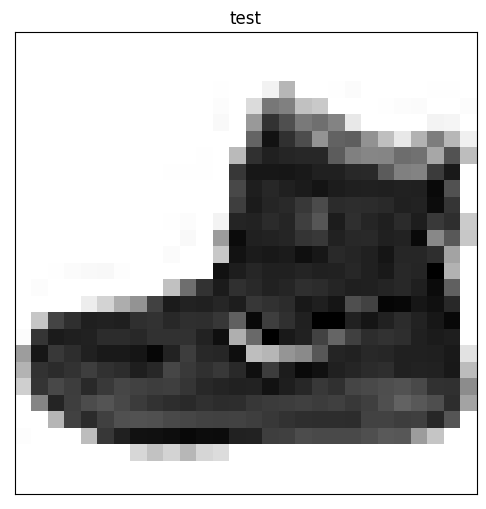

In [105]:
show_image(img, figsize=(6,6), title = "test")

#### From show_image to suplots to show multiple images
It is often necessary to plot multiple images in a grid.  To do so effectively it is necessary to size the imaged appropriated and to only show images where one exists (ie empty spots on the grid should reamin empty. ALso we need to make sure we can add labels to each image

In [107]:
from nbdev.showdoc import show_doc

The showdoc method generates a summary of the arguments for the subplots function but also includes the aspects that can be set using kwargs, which can be very helpful

At present it does not seem to work very well with traditional docstrings, as can be seen below.

In [4]:
#| echo: false
#| output: asis
show_doc(subplots)

---

[source](https://github.com/fastai/fastai-course-22p/blob/master/miniai/datasets.py#L69){target="_blank" style="float:right; font-size:smaller"}

### subplots

>      subplots (nrows:int=1, ncols:int=1, figsize:tuple=None, imsize:float=3,
>                suptitle:str=None, sharex=False, sharey=False, squeeze=True,
>                width_ratios=None, height_ratios=None, subplot_kw=None,
>                gridspec_kw=None, **kwargs)

create grid of axes ready for assignment of images to each axis

nrows (int): number of rows
ncols (int): number of columns
figsize (Tuple[float, float]): Size of overall figure that will be produced in default units
imsize (float): size of individual images in default units
suptitle (Union[str, None]): title for the overall figure

fig: plt.Figure
ax: np.array(plt.Axes)

|    | **Type** | **Default** | **Details** |
| -- | -------- | ----------- | ----------- |
| nrows | int | 1 | Number of rows |
| ncols | int | 1 | Number of columns |
| figsize | tuple | None | Size of overall figure that will be produced in default units |
| imsize | float | 3 | size of individual images in default units |
| suptitle | str | None | Title for the plot |
| sharex | bool | False |  |
| sharey | bool | False |  |
| squeeze | bool | True |  |
| width_ratios | NoneType | None |  |
| height_ratios | NoneType | None |  |
| subplot_kw | NoneType | None |  |
| gridspec_kw | NoneType | None |  |
| kwargs |  |  |  |
| **Returns** | **(plt.Figure, plt.Axes)** |  |  |

The above call can be used as follows:

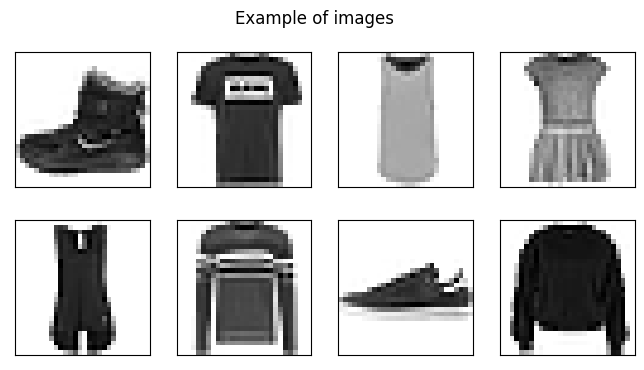

In [109]:
fig, axs = subplots(nrows=2, ncols=4, imsize=2, suptitle="Example of images")
imgs = xb[:8]
for ax, img in zip(axs.flat, imgs): show_image(img, ax)

We can make the function more intelligent by automatically calculating the size of the images and allowing the title to have weight and size defined.  This function can be built on top of the subplots method above

In [5]:
#| echo: false
#| output: asis
show_doc(get_grid)

---

[source](https://github.com/fastai/fastai-course-22p/blob/master/miniai/datasets.py#L101){target="_blank" style="float:right; font-size:smaller"}

### get_grid

>      get_grid (n:int, nrows:int=None, ncols:int=None, title:str=None,
>                weight:str='bold', size:int=14, figsize:tuple=None,
>                imsize:float=3, suptitle:str=None, sharex=False, sharey=False,
>                squeeze=True, width_ratios=None, height_ratios=None,
>                subplot_kw=None, gridspec_kw=None)

|    | **Type** | **Default** | **Details** |
| -- | -------- | ----------- | ----------- |
| n | int |  | Number of axes |
| nrows | int | None | Number of rows |
| ncols | int | None | Number of columns |
| title | str | None | Plot title, optional |
| weight | str | bold | Weight to apply to the title |
| size | int | 14 | size of the title font |
| figsize | tuple | None | Size of overall figure that will be produced in default units |
| imsize | float | 3 | size of individual images in default units |
| suptitle | str | None | Title for the plot |
| sharex | bool | False |  |
| sharey | bool | False |  |
| squeeze | bool | True |  |
| width_ratios | NoneType | None |  |
| height_ratios | NoneType | None |  |
| subplot_kw | NoneType | None |  |
| gridspec_kw | NoneType | None |  |

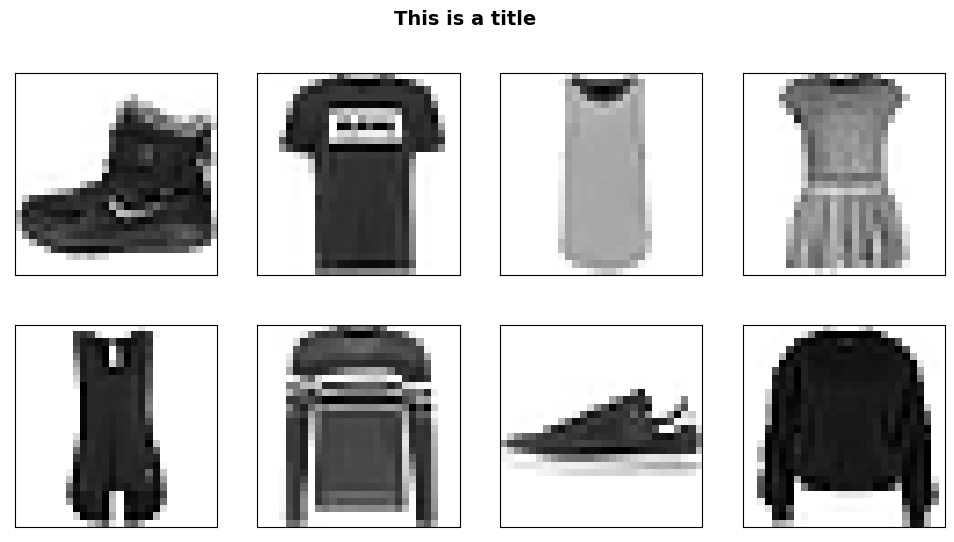

In [111]:
fig, axs = get_grid(8, nrows=2, title="This is a title")
for ax, img in zip(axs.flat, imgs): show_image(img, ax)

Finally it is possible to now create a show_images function that uses show image to display individual images and get_grid to provide the grid of axes upon which to plot them.  We will also pass in the labels for each object so that this can be used as a title for each image

In [6]:
#| echo: false
#| output: asis
show_doc(show_images)

---

[source](https://github.com/fastai/fastai-course-22p/blob/master/miniai/datasets.py#L129){target="_blank" style="float:right; font-size:smaller"}

### show_images

>      show_images (imgs:list, nrows:int=None, ncols:int=None, titles:str=None,
>                   figsize:tuple=None, imsize:float=3, suptitle:str=None,
>                   sharex=False, sharey=False, squeeze=True, width_ratios=None,
>                   height_ratios=None, subplot_kw=None, gridspec_kw=None)

|    | **Type** | **Default** | **Details** |
| -- | -------- | ----------- | ----------- |
| imgs | list |  | List of images to show |
| nrows | int | None | Number of rows |
| ncols | int | None | Number of columns |
| titles | str | None | Plot title, optional, list of titles for each image |
| figsize | tuple | None | Size of overall figure that will be produced in default units |
| imsize | float | 3 | size of individual images in default units |
| suptitle | str | None | Title for the plot |
| sharex | bool | False |  |
| sharey | bool | False |  |
| squeeze | bool | True |  |
| width_ratios | NoneType | None |  |
| height_ratios | NoneType | None |  |
| subplot_kw | NoneType | None |  |
| gridspec_kw | NoneType | None |  |

In [113]:
b = next(iter(dl))
xb = b['image'][:8]
yb = b['label'][:8]

In [114]:
names = featy.names
# itemgetter will lookup the item in the following object and attempt to retrieve it by the "key" given
# in this case the key is taken as an index, since the object that follows is a list
labels = itemgetter(*yb)(names)

In [115]:
labels

('Ankle boot',
 'T - shirt / top',
 'T - shirt / top',
 'Dress',
 'T - shirt / top',
 'Pullover',
 'Sneaker',
 'Pullover')

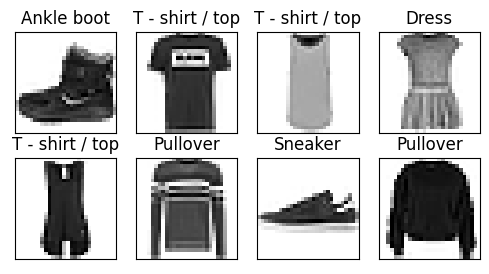

In [116]:
show_images(xb, titles=labels, nrows=2, imsize=1.5)

## Export 

In [117]:
import nbdev; nbdev.nbdev_export()

NotImplementedError: Unexpected format in '/Users/johnrichmond/git_repro/fastai-course-22p/miniai/conv.py' at cell:
```
# %% ../nbs/07 - Convolutions.ipynb 2
import pickle,gzip,math,os,time,shutil,torch,matplotlib as mpl, numpy as np
import pandas as pd,matplotlib.pyplot as plt
from pathlib import Path
from torch import tensor
from torch import nn

from torch.utils.data import DataLoader,default_collate
from typing import Mapping

from .training import *
from .datasets import *.
```
The expected format is: '# %% {nb_path} {cell_idx}'.